In [6]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import os

Using event file: events\both\events.out.tfevents.1748413984.i07.2033823.0


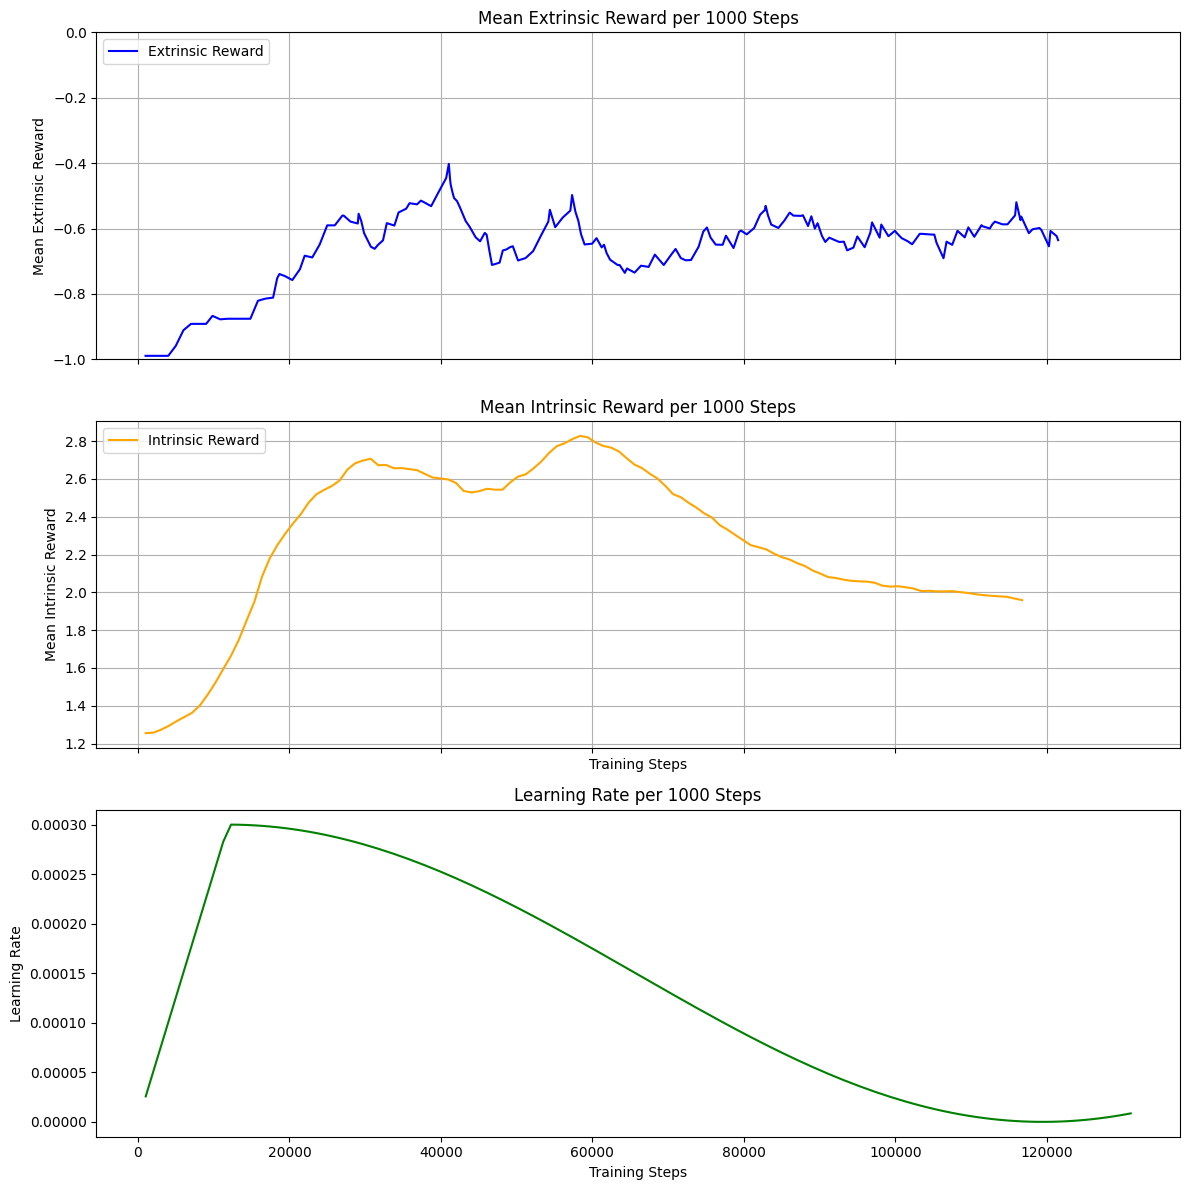

In [76]:
import os
import glob
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def plot_last_event_rewards(reward_mode='both'):
    event_dir = os.path.join('events', reward_mode)
    # Find all event files in the directory
    event_files = glob.glob(os.path.join(event_dir, 'events.out.tfevents.*'))
    
    # Pick the latest event file
    event_files = glob.glob(os.path.join(event_dir, 'events.out.tfevents.*'))
    if len(event_files) < 2:
        print(f"Not enough event files found in {event_dir}")
        return
    event_path = sorted(event_files, key=os.path.getctime)[-1]
    print(f"Using event file: {event_path}")

    # Load TensorBoard event data
    ea = event_accumulator.EventAccumulator(event_path)
    ea.Reload()

    # Extract scalar data
    extr_events = ea.Scalars('Mean_extr_reward_per_1000_steps')
    intr_events = ea.Scalars('Mean_intr_reward_per_1000_steps')
    lr_events = ea.Scalars('Learning_Rate')

    # Convert to lists
    steps_extr = [e.step for e in extr_events]
    values_extr = [e.value for e in extr_events]
    steps_intr = [e.step for e in intr_events]
    values_intr = [e.value for e in intr_events]
    lr_values = [e.value for e in lr_events]
    steps_lr = [e.step for e in lr_events]

    # COnvert to a running average
    def running_average(values, window_size=15):
        return [sum(values[i:i + window_size]) / window_size for i in range(len(values) - window_size + 1)]
    values_extr = running_average(values_extr)
    values_intr = running_average(values_intr)
    steps_extr = steps_extr[:len(values_extr)]
    steps_intr = steps_intr[:len(values_intr)]

    # Plot with two subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # Extrinsic reward subplot
    axs[0].plot(steps_extr, values_extr, label='Extrinsic Reward', color='blue')
    axs[0].set_ylabel('Mean Extrinsic Reward')
    axs[0].set_title('Mean Extrinsic Reward per 1000 Steps')
    axs[0].grid(True)
    axs[0].legend(loc='upper left')
    # Put the yscale between 0 and 1
    axs[0].set_ylim(-1, 0)

    # Intrinsic reward subplot
    axs[1].plot(steps_intr, values_intr, label='Intrinsic Reward', color='orange')
    axs[1].set_xlabel('Training Steps')
    axs[1].set_ylabel('Mean Intrinsic Reward')
    axs[1].set_title('Mean Intrinsic Reward per 1000 Steps')
    axs[1].grid(True)
    axs[1].legend(loc='upper left')
    
    # Learning rate subplot
    axs[2].plot(steps_lr, lr_values, label='Learning Rate', color='green')
    axs[2].set_xlabel('Training Steps')
    axs[2].set_ylabel('Learning Rate')
    axs[2].set_title('Learning Rate per 1000 Steps')

    plt.tight_layout()
    plt.show()
    
plot_last_event_rewards('both')        # or 'intrinsic', 'extrinsic'

Using event file: events/both\events.out.tfevents.1748383102.Charled.76128.0
Using event file: events/both\events.out.tfevents.1748413984.i07.2033823.0


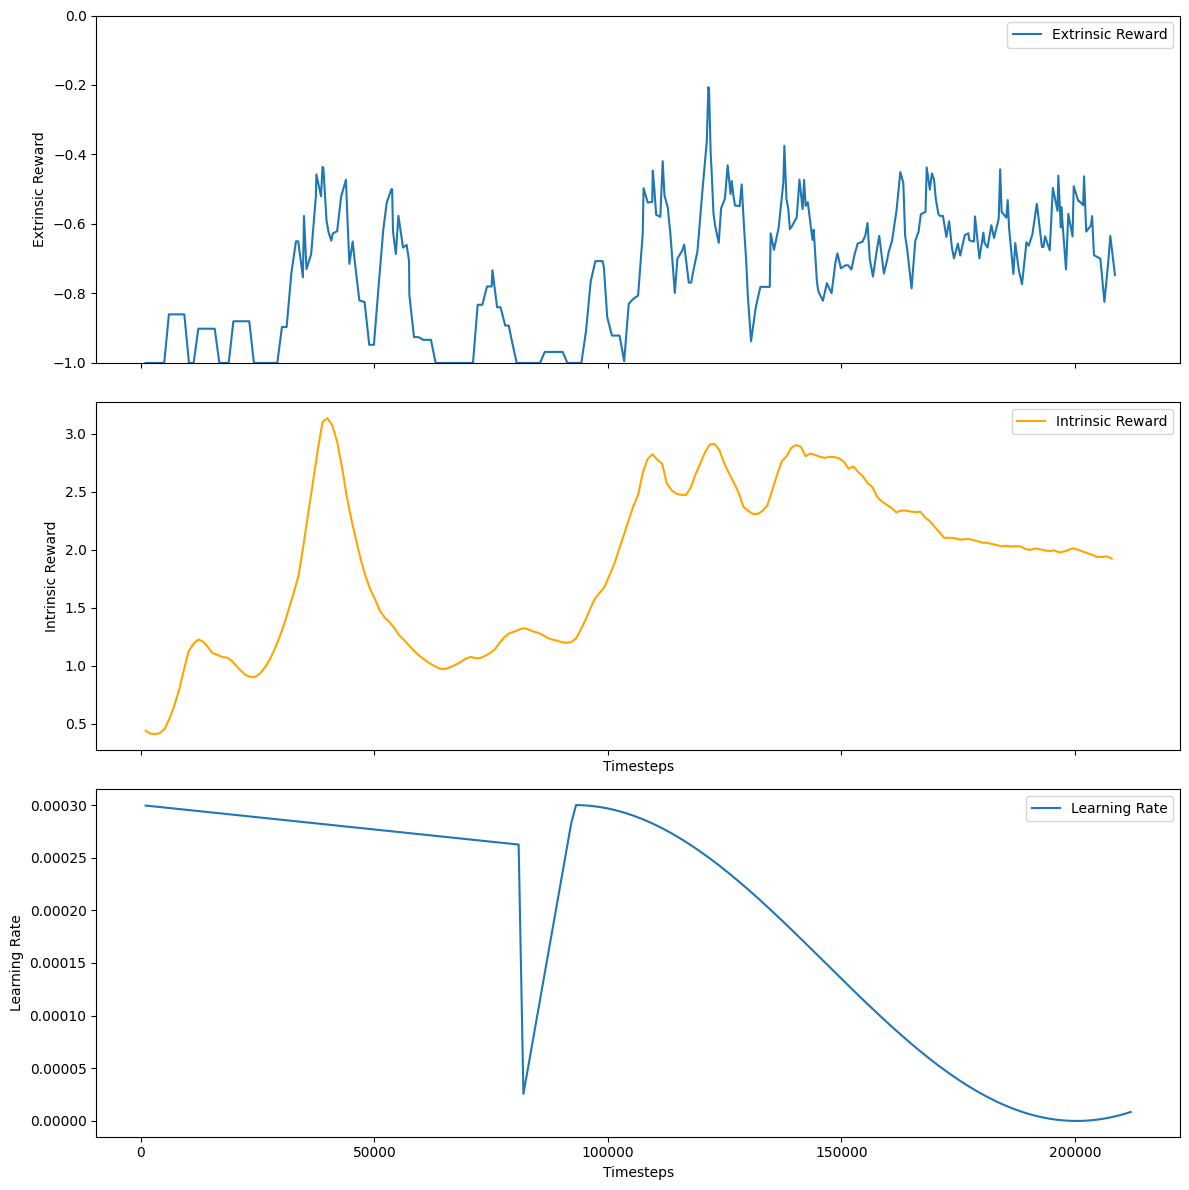

In [75]:
import os
import glob
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def get_event_file(event_dir, which=-1):
    """Get the nth-to-last event file from a directory."""
    
    event_files = glob.glob(os.path.join(event_dir, 'events.out.tfevents.*'))
    event_path = sorted(event_files, key=os.path.getctime)[which]
    print(f"Using event file: {event_path}")    
    return event_path

def extract_scalar(event_file, tag):
    """Extract (steps, values) for a given scalar tag from a TensorBoard event file."""
    ea = event_accumulator.EventAccumulator(event_file)
    ea.Reload()
    if tag not in ea.Tags()['scalars']:
        raise ValueError(f"Tag '{tag}' not found in {event_file}")
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    return steps, values

def plot_concatenated_rewards(
    file1, file2,
    extr_tag='Mean_extr_reward_per_1000_steps',
    intr_tag='Mean_intr_reward_per_1000_steps',
    lr_tag1='Lr',
    lr_tag2='Learning_Rate'
):
    # Extract extrinsic and intrinsic rewards from both files
    steps1_extr, rewards1_extr = extract_scalar(file1, extr_tag)
    steps2_extr, rewards2_extr = extract_scalar(file2, extr_tag)
    steps1_intr, rewards1_intr = extract_scalar(file1, intr_tag)
    steps2_intr, rewards2_intr = extract_scalar(file2, intr_tag)
    steps1_lr, lr1 = extract_scalar(file1, lr_tag1)
    steps2_lr, lr2 = extract_scalar(file2, lr_tag2)

    # Concatenate
    steps_extr = steps1_extr + [s + steps1_extr[-1] for s in steps2_extr]
    rewards_extr = rewards1_extr + rewards2_extr
    steps_intr = steps1_intr + [s + steps1_intr[-1] for s in steps2_intr]
    rewards_intr = rewards1_intr + rewards2_intr
    lr = lr1 + lr2
    steps_lr = steps1_lr + [s + steps1_lr[-1] for s in steps2_lr]
    
    # COnvert to a running average
    def running_average(values, window_size=5):
        return [sum(values[i:i + window_size]) / window_size for i in range(len(values) - window_size + 1)]
    rewards_extr = running_average(rewards_extr)
    rewards_intr = running_average(rewards_intr)
    steps_extr = steps_extr[:len(rewards_extr)]
    steps_intr = steps_intr[:len(rewards_intr)]

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    axs[0].plot(steps_extr, rewards_extr, label='Extrinsic Reward')
    axs[0].set_ylabel('Extrinsic Reward')
    axs[0].legend()
    axs[0].set_ylim(-1, 0)  # Assuming extrinsic rewards are negative
    axs[1].plot(steps_intr, rewards_intr, label='Intrinsic Reward', color='orange')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Intrinsic Reward')
    axs[1].legend()
    axs[2].plot(steps_lr, lr, label='Learning Rate')
    axs[2].set_xlabel('Timesteps')
    axs[2].set_ylabel('Learning Rate')
    axs[2].legend()
    plt.tight_layout()
    plt.show()

# Example usage:
file1 = get_event_file('events/both/', which=-9)        # second to last
file2 = get_event_file('events/both/', which=-1)   # third to last
plot_concatenated_rewards(file1, file2)